# Alternative pruning strategies

PLSCAN's condensed tree can also be pruned with other thresholds. For example,
rather than pruning by the cluster size, we can prune by persistence or excess
of mass instead. This notebook explores these ideas.

In [1]:
import numpy as np
from plscan import PLSCAN
from plscan.plots import PersistenceTrace as PersistenceTracePlot
from plscan._helpers import most_persistent_clusters
from plscan._api import (
    LeafTree,
    compute_size_persistence,
    compute_cluster_labels,
    apply_size_cut,
)

from lib.plotting import *

configure_matplotlib()  # uses latex for text rendering!
data = np.load("data/clusterable/sources/clusterable_data.npy")

Compute PLSCAN normally first, so we have data structures to work on.

In [2]:
c = PLSCAN(min_samples=5).fit(data)

Segments in the condensed tree have an excess of mass (area) and distance
persistence (height). Like the cluster size (width), these features
monotonically increase along the tree. So, we can use them to prune leaves,
analogous to pruning with a minimum cluster size.

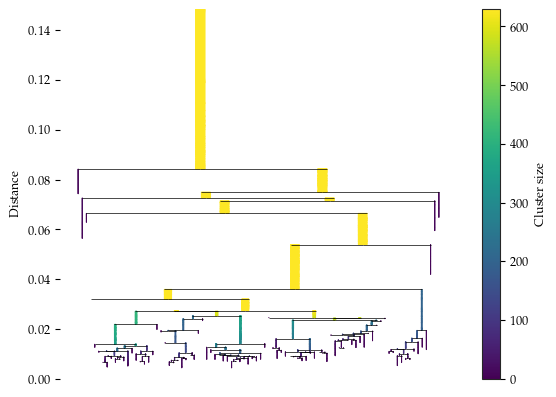

In [3]:
c.condensed_tree_.plot()
plt.show()

## Persistence pruning

First, let's try [persistence pruning](https://arxiv.org/abs/1105.0540). This
cell adapts the leaf-tree construction procedure to track density persistence
lifetimes instead of cluster size lifetimes. The structure is the same. We visit
each merge in the condensed tree and track the persistence threshold at which
one of the siblings stops existing. To compute persistences, we also propagate
the lowest birth distance in each sub-tree, ensuring a monotonic pruning
behavior.

In [ ]:
n = data.shape[0]
lt = c._leaf_tree
ct = c._condensed_tree
num_clusters = len(ct.cluster_rows)

# To-be-computed persistence birth
min_pers = np.zeros(num_clusters + 2)
# To-be-computed persistence death
max_pers = np.empty(num_clusters + 2)
# Lowest distances where clusters appears
min_dists = np.empty(num_clusters + 2)
min_dists[ct.parent - n] = ct.distance

# Leaf-tree construction: bottom-up condensed-tree traversal
for i in range(1, num_clusters, 2):
    idx = num_clusters - i
    left_row, right_row = ct.cluster_rows[[idx - 1, idx]]
    left_idx, right_idx = ct.child[[left_row, right_row]]
    left, right = left_idx - n, right_idx - n
    parent = ct.parent[left_row] - n
    dist = ct.distance[left_row]

    min_peak, max_peak = sorted(min_dists[[left, right]])
    # Propagate lowest birth-distance to parent
    min_dists[parent] = min_peak
    # Least persistent child sets both death values
    max_pers[[left, right]] = np.exp(-max_peak) - np.exp(-dist)
    # Delay parent birth for potential downstream leaves
    min_pers[parent] = max(max_pers[left], min_pers[left], min_pers[right])
    # Also update (phantom) root cluster
    if lt.parent[parent] == 0:
        min_pers[0] = max(min_pers[0], min_pers[parent])

# Finalize values for (phantom) roots
mask = np.where(lt.parent == 0)[0][1:]
max_pers[0] = np.exp(-min_dists[mask].min()) - np.exp(-ct.distance[ct.cluster_rows[0]])
max_pers[mask] = min_pers[0]

Now, we can plug the computed values into the leaf-tree structure and compute
PLSCAN as if nothing changed!

In [5]:
lt = LeafTree(
    c._leaf_tree.parent,
    c._leaf_tree.min_distance,
    c._leaf_tree.max_distance,
    min_pers.astype(np.float32),
    max_pers.astype(np.float32),
)
pt = compute_size_persistence(lt)  # size is now persistence!
sc = most_persistent_clusters(lt, pt)
l, p = compute_cluster_labels(lt, ct, sc, n)

The persistence trace is much more focussed on clusterings with many small
clusters. PLSCAN's original leaf clusters are coloured in the barcode,
indicating thresholds around 0.01 would be appropriate.

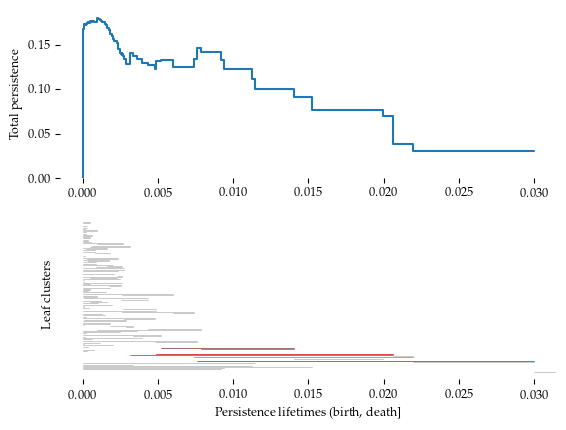

In [6]:
plt.subplot(2, 1, 1)
PersistenceTracePlot(pt).plot()
xlim = plt.xlim()
plt.xlabel("")

plt.subplot(2, 1, 2)
cnt = 0
for k, (i, a) in enumerate(zip(min_pers, max_pers)):
    if i > a:
        continue
    if k in c.selected_clusters_:
        idx = np.where(c.selected_clusters_ == k)[0][0]
        plt.plot([i, a], [cnt, cnt], color=f"C{idx}", linewidth=0.6)
    else:
        plt.plot([i, a], [cnt, cnt], color="silver", linewidth=0.6)
    cnt += 1
plt.xlim(xlim)
plt.xlabel("Persistence lifetimes (birth, death]")
plt.yticks([])
plt.ylabel("Leaf clusters")

plt.show()

The best threshold around 0.014 includes a noise cluster.

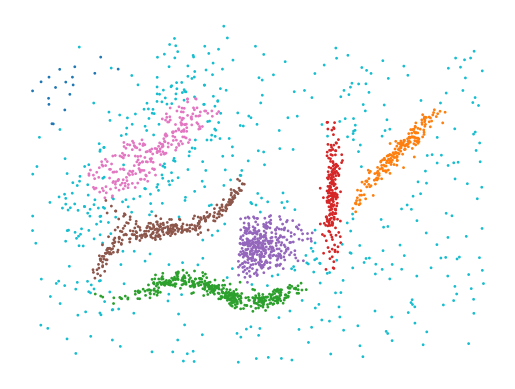

In [7]:
sc = apply_size_cut(lt, 0.014)
l, p = compute_cluster_labels(lt, ct, sc, n)

plt.scatter(*data.T, c=l % 10, cmap="tab10", s=1)
plt.axis("off")
plt.show()

## EOM pruning

Now, lets try [EOM
pruning](http://www.tandfonline.com/doi/abs/10.1198/jcgs.2009.07049). First, we
compute the maximum distance at which each condensed tree cluster segment
exists. Then, we compute the relative excess of mass for each cluster segment.
Finally, we perform the leaf-tree construction, propagating the computed excess
of mass values up the tree to ensure monotonic pruning.

In [ ]:
# Compute maximum distance for each cluster segment
max_dists = np.full(num_clusters + 2, ct.distance[0])
max_dists[ct.child[ct.cluster_rows] - n] = ct.distance[ct.cluster_rows]

# Compute relative excess of mass for each segment
seg_eom = np.zeros(num_clusters + 2)
for parent, dist, size in zip(ct.parent, ct.distance, ct.child_size):
    seg_eom[parent - n] += (np.exp(-dist) - np.exp(-max_dists[parent - n])) * size

# Compute EOM lifetimes
min_eom = np.zeros(num_clusters + 2)
max_eom = np.empty(num_clusters + 2)
for i in range(1, num_clusters, 2):
    idx = num_clusters - i
    left_row, right_row = ct.cluster_rows[[idx - 1, idx]]
    left_idx, right_idx = ct.child[[left_row, right_row]]
    left, right = left_idx - n, right_idx - n
    parent = ct.parent[left_row] - n

    lower_eom, upper_eom = sorted(seg_eom[[left, right]])
    # Accumulate EOM to parent for monotonic pruning!
    seg_eom[parent] += lower_eom + upper_eom
    # Least persistent child sets both death values
    max_eom[[left, right]] = lower_eom
    # Delay parent birth for potential downstream leaves
    min_eom[parent] = max(max_eom[left], min_eom[left], min_eom[right])
    # Also update (phantom) root cluster
    if lt.parent[parent] == 0:
        min_eom[0] = max(min_eom[0], min_eom[parent])

# Finalize values for (phantom) roots
mask = np.where(lt.parent == 0)[0][1:]
max_eom[0] = seg_eom[0] + min_eom[mask].sum()
max_eom[mask] = min_eom[0]

Now, we can again plug the values in and continue computing PLSCAN clusters.

In [9]:
lt = LeafTree(
    c._leaf_tree.parent,
    c._leaf_tree.min_distance,
    c._leaf_tree.max_distance,
    min_eom.astype(np.float32),
    max_eom.astype(np.float32),
)
pt = compute_size_persistence(lt)  # size is now EOM!
sc = most_persistent_clusters(lt, pt)
l, p = compute_cluster_labels(lt, ct, sc, n)

The resulting persistence trace focusses on fewer but larger clusters, blending
the original PLSCAN with the persistence pruning from above.

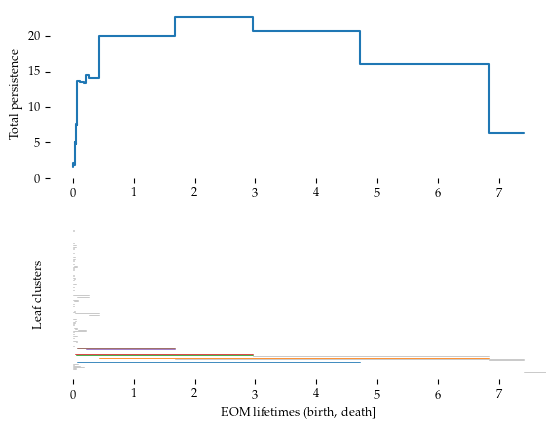

In [10]:
plt.subplot(2, 1, 1)
PersistenceTracePlot(pt).plot()
xlim = plt.xlim()
plt.xlabel("")

plt.subplot(2, 1, 2)
cnt = 0
for k, (i, a) in enumerate(zip(min_eom, max_eom)):
    if i > a:
        continue
    if k in c.selected_clusters_:
        idx = np.where(c.selected_clusters_ == k)[0][0]
        plt.plot([i, a], [cnt, cnt], color=f"C{idx}", linewidth=.6)
    else:
        plt.plot([i, a], [cnt, cnt], color="silver", linewidth=.6)
    cnt += 1
plt.xlim(xlim)
plt.xlabel("EOM lifetimes (birth, death]")
plt.yticks([])
plt.ylabel("Leaf clusters")

plt.show()

A reasonable clustering is found at threshold 1.0. Unfortunately, this is not a
peak in the persistence trace.

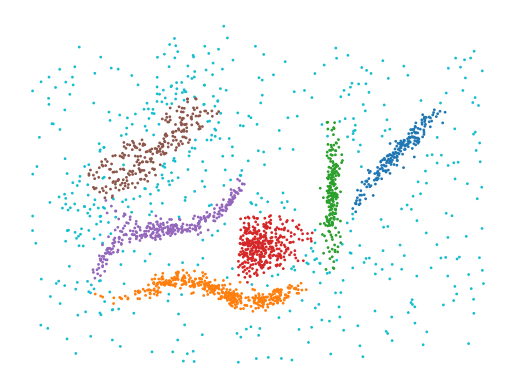

In [11]:
sc = apply_size_cut(lt, 1)
l, p = compute_cluster_labels(lt, ct, sc, n)

plt.scatter(*data.T, c=l % 10, cmap="tab10", s=1)
plt.axis("off")
plt.show()

## Normal PLSCAN.

The normal PLSCAN persistence trace produces a peak for the optimal clustering:

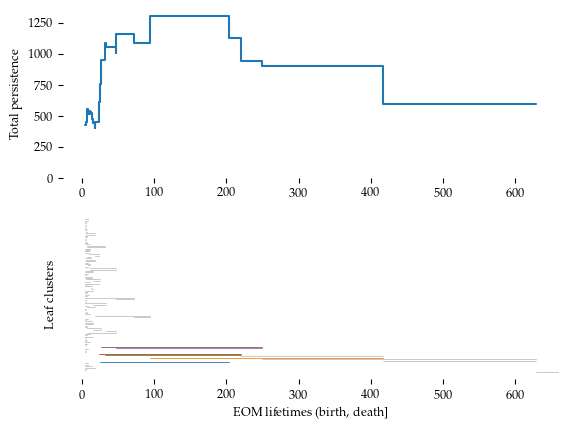

In [12]:
plt.subplot(2, 1, 1)
c.persistence_trace_.plot()
xlim = plt.xlim()
plt.xlabel("")

plt.subplot(2, 1, 2)
cnt = 0
for k, (i, a) in enumerate(zip(c._leaf_tree.min_size, c._leaf_tree.max_size)):
    if i >= a:
        continue
    if k in c.selected_clusters_:
        idx = np.where(c.selected_clusters_ == k)[0][0]
        plt.plot([i, a], [cnt, cnt], color=f"C{idx}", linewidth=0.6)
    else:
        plt.plot([i, a], [cnt, cnt], color="silver", linewidth=0.6)
    cnt += 1
plt.xlim(xlim)
plt.xlabel("EOM lifetimes (birth, death]")
plt.yticks([])
plt.ylabel("Leaf clusters")

plt.show()